# 时间序列经典模型
时间序列经典模型主要分为四种：自回归模型AR，移动回归模型MA，两种的结合移动自回归模型ARMA，以及差分移动自回归模型ARIMA

## AR模型
因变量能由它的多个滞后项表示称为自回归模型（AR）。  
p阶自回归模型可以写成：
$$x_t=\phi_0+\phi_1x_{t-1}+\phi_2x_{t-2}+...+\phi_px_{t-p}+\mu_t$$
$x_{t-p}是x_t的滞后p阶，\phi_p为自回归系数，\mu_t为白噪音，满足标准正态分布$。  

模拟一个AR(1)模型，让 $\phi_{0}为零， \phi_{1}$ 等于0.8

In [61]:
import pandas as pd
import numpy as np
import statsmodels.tsa.api as smt     
#tsa为Time Series analysis缩写
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model
#画图
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
#正常显示画图时出现的中文和负号
from pylab import mpl
mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False

In [63]:
def ts_plot(data, lags=None,title=''):
    if not isinstance(data, pd.Series):   
        data = pd.Series(data)
    #matplotlib官方提供了五种不同的图形风格，
    #包括bmh、ggplot、dark_background、fivethirtyeight和grayscale
    with plt.style.context('ggplot'):    
        fig = plt.figure(figsize=(10, 8))
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))

        data.plot(ax=ts_ax)
        ts_ax.set_title(title+'时序图')
        smt.graphics.plot_acf(data, lags=lags, ax=acf_ax, alpha=0.5)
        acf_ax.set_title('自相关系数')
        smt.graphics.plot_pacf(data, lags=lags, ax=pacf_ax, alpha=0.5)
        pacf_ax.set_title('偏自相关系数')
        sm.qqplot(data, line='s', ax=qq_ax)
        qq_ax.set_title('QQ 图')        
        scs.probplot(data, sparams=(data.mean(), data.std()), plot=pp_ax)
        pp_ax.set_title('PP 图') 
        plt.tight_layout()
    return

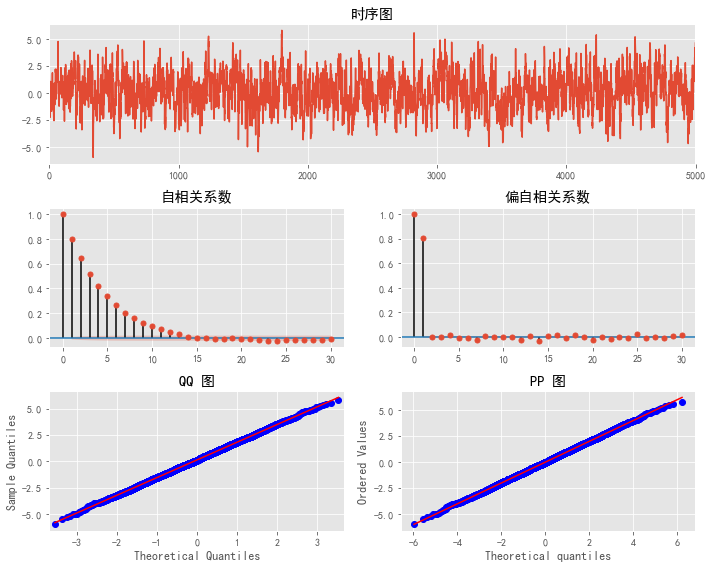

In [64]:
# 模拟AR(1) 过程 
#设置随机种子（括号里数字无意义）
np.random.seed(1)
#模拟次数
n=5000
#AR模型的参数
a = 0.8
#扰动项为正态分布
x = w = np.random.normal(size=n)
for t in range(1,n):
    x[t] = a*x[t-1] + w[t]
#画图
ts_plot(x, lags=30)

模拟的AR(1)模型是正态的。自相关系数图（ACF）显示滞后值之间存在显著的序列相关性，偏自相关系数图（PACF）则显示在滞后1期时截尾（迅速降为0）。下面使用statsmodels构建AR(p)模型,先用AR模型拟合上述模拟的数据，并返回估计的系数参数（$\phi$），然后选择最佳滞后阶数，最后与原模型设置对比看是否选择了正确的滞后项。假如AR模型是正确的，那估计的系数参数将很接近真实的系数0.8，选择的阶数也会等于1。

In [65]:
#估计数据的AR模型参数和滞后阶数
def simu_ar(data,a,maxlag=30,true_order = 1):
    '''data:要拟合的数据；a为参数,可以为列表；maxlag:最大滞后阶数'''
    # 拟合AR(p)模型
    result = smt.AR(data).fit(maxlag=maxlag, ic='aic', trend='nc')
    #选择滞后阶数
    est_order = smt.AR(data).select_order(maxlag=maxlag, ic='aic', trend='nc')  
    #参数选择标准ic : 有四个选择 {‘aic’,’bic’,’hqic’,’t-stat’}
    #趋势项：trend：c是指包含常数项，nc为不含常数项
    #打印结果
    print(f'参数估计值：{result.params.round(2)}，估计的滞后阶数：{est_order}')
    print(f'真实参数值：{a}，真实滞后阶数 {true_order}')

In [66]:
simu_ar(x,a=0.8)

参数估计值：[0.8]，估计的滞后阶数：1
真实参数值：0.8，真实滞后阶数 1


看下如何用AR(p)模型来拟合沪深300的对数收益

沪深300拟合AR模型的参数：[ 0.03 -0.03  0.03  0.05  0.   -0.06  0.04  0.01  0.02  0.01  0.02  0.02
  0.06 -0.03  0.05]
沪深300拟合AR模型的最佳滞后阶数 15


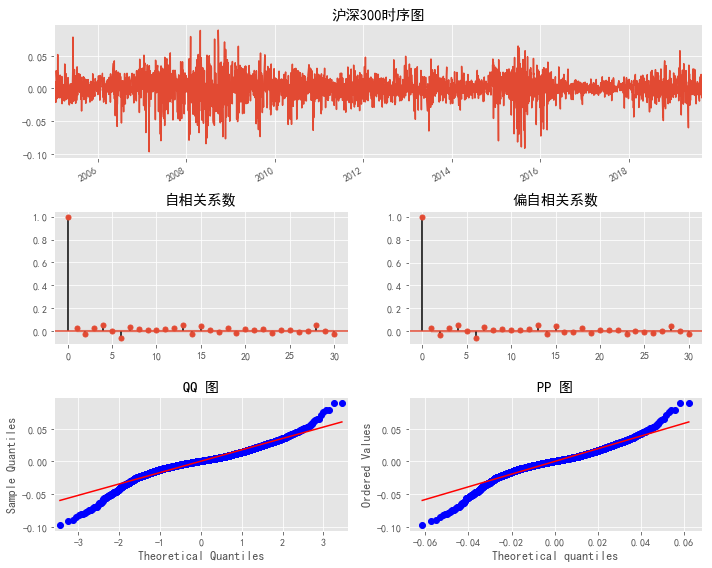

In [136]:
# Select best lag order for hs300 returns
import tushare as ts
token='输入token'
pro=ts.pro_api(token)
df=pro.index_daily(ts_code='000300.SH')
df.index=pd.to_datetime(df.trade_date)
del df.index.name
df=df.sort_index()
df['ret']=np.log(df.close/df.close.shift(1))
max_lag = 30
Y=df.ret.dropna()
ts_plot(Y,lags=max_lag,title='沪深300')
result = smt.AR(Y.values).fit(maxlag=max_lag, ic='aic', trend='nc')
est_order = smt.AR(Y.values).select_order(maxlag=max_lag, ic='aic', trend='nc')
print(f'沪深300拟合AR模型的参数：{result.params.round(2)}')
print(f'沪深300拟合AR模型的最佳滞后阶数 {est_order}')

最好的阶数选择是15或者有15个参数！任何模型有这么参数在实际中不可能有用。显然有比这个模型更复杂的模型可以解释

## MA模型
MA(q)模型与AR(p)模型非常相似。不同之处在于，MA(q)模型是对过去的白噪声误差项的线性组合，而不是过去观测的线性组合。MA模型的动机是我们可以直接通过拟合误差项的模型来观察误差过程中的“冲击”。在一个AR(p)模型中，通过在一系列过去的观察中使用ACF间接观察到这些冲击。MA(q)模型的公式是：

$$x_{t}=c_{0}+\omega _{t}+\beta _{1}\omega _{t-1}+...+\beta _{p}\omega _{t-p},\\其中\omega 是白噪声， E(\omega_{t})=0 ，方差是 \sigma_{a}^{2}$$


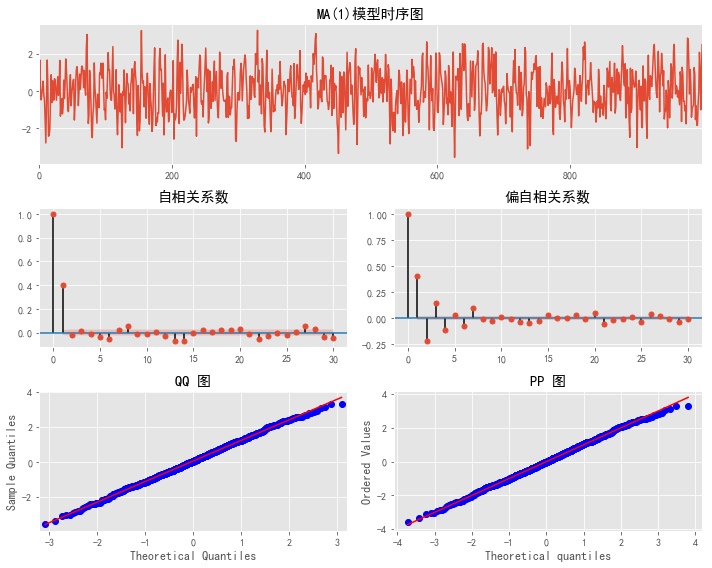

In [75]:
# 模拟MA(1) 过程
#这里使用arma模型进行模拟，设定ar阶数为0，即得到ma模型
alphas = np.array([0.])
betas = np.array([0.6])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]
#模拟MA的样本数据
ma_sample = smt.arma_generate_sample(ar=ar, ma=ma, nsample=1000) 
ts_plot(ma_sample, lags=30,title='MA(1)模型')

ACF函数显示滞后1阶系数显著异于0，表明MA（1）模型适合拟合的数据。

In [69]:
# 对上述模拟数据进行ARMA模型拟合
max_lag = 30
result = smt.ARMA(ma1, order=(0, 1)).fit(maxlag=max_lag, method='mle', trend='nc')
print(result.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 1)   Log Likelihood               -1368.563
Method:                           mle   S.D. of innovations              0.951
Date:                Wed, 28 Aug 2019   AIC                           2741.126
Time:                        10:44:49   BIC                           2750.942
Sample:                             0   HQIC                          2744.857
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        0.6277      0.024     26.112      0.000       0.581       0.675
                                    Roots                                    
                  Real          Imaginary           M

模型估计d 滞后系数为0.6277，与真实值0.6比较接近。注意到，95％置信区间确实包含该真实值。

下面尝试用MA(3)模型去拟合沪深300股价的对数收益，但这次并不知道真实的参数值。

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 3561
Model:                     ARMA(0, 3)   Log Likelihood                9371.549
Method:                           mle   S.D. of innovations              0.017
Date:                Wed, 28 Aug 2019   AIC                         -18735.098
Time:                        14:36:41   BIC                         -18710.387
Sample:                             0   HQIC                        -18726.287
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        0.0247      0.017      1.462      0.144      -0.008       0.058
ma.L2.y       -0.0272      0.016     -1.700      0.089      -0.059       0.004
ma.L3.y        0.0341      0.018      1.892      0.0

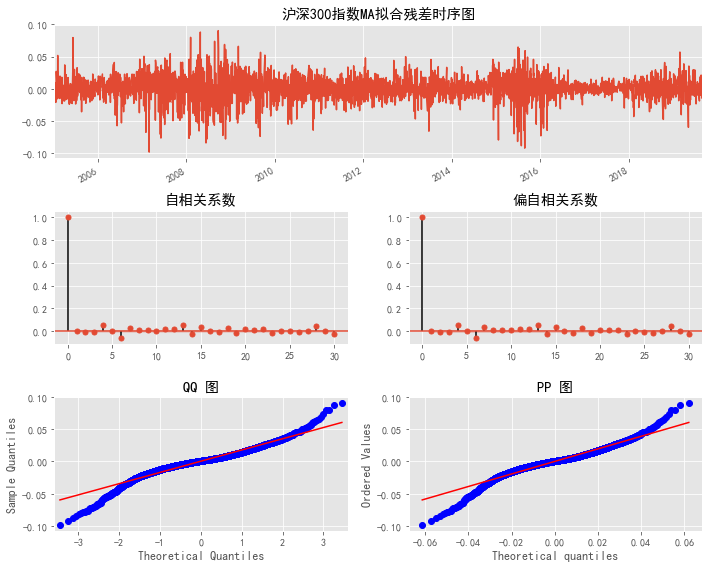

In [138]:
max_lag = 30
result = smt.ARMA(Y.values, order=(0, 3)).fit(maxlag=max_lag, method='mle', trend='nc')
print(result.summary())
resid=pd.Series(result.resid,index=Y.index)
ts_plot(resid, lags=max_lag,title='沪深300指数MA拟合残差')

结果显示，拟合的残差自相关系数和偏自相关系数比较符合白噪声过程，但由于存在厚尾，MA模型并不是预测沪深300未来回报的最佳模型。

## ARMA模型
自回归移动平均模型Autoregressive Moving Average Models - ARMA(p, q)  

ARMA模型是AR（p）和MA（q）模型之间的结合，从金融的角度理解，AR和MA模型的理论意义在于：

1. AR（p）模型试图捕捉（解释）交易市场中经常观察到的动量和均值回复效应。  
2. MA（q）模型尝试捕捉（解释）在白噪声条件下观察到的冲击效应。这些冲击效应可以被认为是影响观察过程的意外事件，例如，恐怖袭击  

ARMA模型的弱点在于忽视了大多数金融时间序列中的波动聚集效应。

模型的公式可以表示为:

$$x_{t}=\alpha_{0}+\alpha_{1}x_{t-1}+\alpha_{2}x_{t-2}+...+\omega_{t}+\beta _{1}\omega _{t-1}+\beta _{2}\omega _{t-2}+...+\beta _{q}\omega _{t-q}\\=\alpha _{0}+\sum_{i=1}^{p}\alpha _{i}x_{t-i}+\omega _{t}+\sum_{i=1}^{q}\beta _{i}\omega _{t-i}$$


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 5000
Model:                     ARMA(2, 2)   Log Likelihood               -7064.968
Method:                           mle   S.D. of innovations              0.994
Date:                Wed, 28 Aug 2019   AIC                          14139.937
Time:                        10:59:41   BIC                          14172.523
Sample:                             0   HQIC                         14151.358
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.4551      0.060      7.628      0.000       0.338       0.572
ar.L2.y       -0.2276      0.015    -14.740      0.000      -0.258      -0.197
ma.L1.y        0.5179      0.061      8.548      0.0

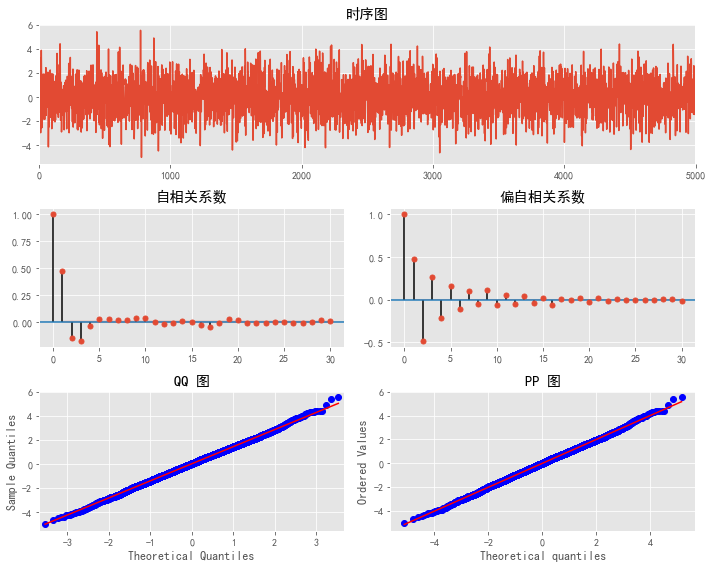

In [71]:
# 下面使用ARMA(2, 2) 模型进行模拟分析
max_lag = 30
n = 5000
burn = int(n/10) 
alphas = np.array([0.5, -0.25])
betas = np.array([0.5, -0.3])
#注意ar模型1代表0阶（自身），然后在其他系数前加负号
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]
arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = ts_plot(arma22, lags=max_lag)
result = smt.ARMA(arma22, order=(2, 2)).fit(maxlag=max_lag, method='mle', trend='nc', burnin=burn)
print(result.summary())

结果显示模型估计的参数与真实参数基本上吻合。下面使用ARMA模型来拟合沪深300的收益数据。

最佳滞后阶数:(4, 4)
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 3561
Model:                     ARMA(4, 4)   Log Likelihood                9388.274
Method:                           mle   S.D. of innovations              0.017
Date:                Wed, 28 Aug 2019   AIC                         -18758.548
Time:                        14:38:10   BIC                         -18702.948
Sample:                             0   HQIC                        -18738.722
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.2360      0.090      2.631      0.009       0.060       0.412
ar.L2.y       -0.0563      0.114     -0.494      0.621      -0.280       0.167
ar.L3.y       -0.0165      0.078     -

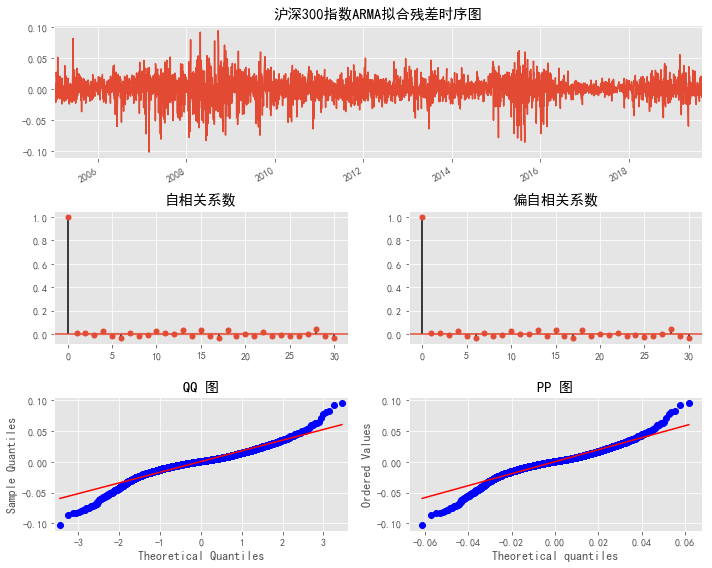

In [139]:
#不事先确定滞后阶数，而是通过信息准则选择最佳的滞后阶数
#先将初始值设置为无穷大
best_aic = np.inf 
best_order = None
best_mdl = None
rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(Y.values, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue
print(f'最佳滞后阶数:{best_order}')
print(best_mdl.summary())
resid=pd.Series(best_mdl.resid,index=Y.index)
ts_plot(resid, lags=30,title='沪深300指数ARMA拟合残差')

ACF和PACF没有显示出明显的自相关性。QQ和概率图显示残差大致为正态分布但厚尾。总体而言，这个模型的残差看起来不像白噪声，说明模型还是没有很好的拟合其波动性特性。

## ARIMA模型
ARIMA模型全称是差分移动自回归模型（Autoregressive Integrated Moving Average Models），是ARMA模型的拓展。由于现实中很多时间序列不是平稳的，但可以通过差分来实现平稳，即通过一阶差分可以将非平稳机游走其转化为平稳的白噪声。由于前三个模型都有时间序列平稳的假设在，如果时间序列存在明显的上升或者下降趋势，模型预测的效果大大折扣。对于有明显下降或者上升趋势的数据集，可以使用差分的方式将其转化为平稳序列，然后使用ARMA模型进行拟合。假设模型经过d次差分通过了时间序列平稳的检验，ARMA的系数为p，q，ARIMA模型为ARIMA(p，d，q）。  
在Python中，如果需要不止一次的差分一个时间系列，需要使用np.diff（）函数。Pandas里的DataFrame.diff（）/ Series.diff（）仅能差分一次，不能实现时间序列的递归差分。

下面通过迭代（p，d，q）的不同组合，找到拟合沪深300收益率数据的最佳ARIMA模型。通过AIC信息准则来评估每个模型，最后选取AIC最小的。

ARIMA模型最佳阶数选择：(4, 0, 4)
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 3561
Model:                     ARMA(4, 4)   Log Likelihood                9388.274
Method:                           mle   S.D. of innovations              0.017
Date:                Wed, 28 Aug 2019   AIC                         -18758.548
Time:                        14:40:45   BIC                         -18702.948
Sample:                             0   HQIC                        -18738.722
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.2360      0.090      2.631      0.009       0.060       0.412
ar.L2.y       -0.0563      0.114     -0.494      0.621      -0.280       0.167
ar.L3.y       -0.0165      0

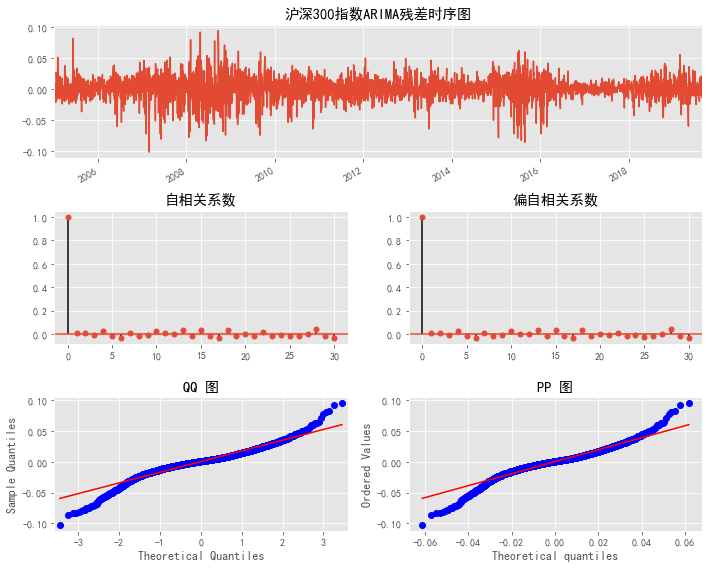

In [140]:
#原理与拟合ARMA模型类似
best_aic = np.inf 
best_order = None
best_mdl = None
#假定最多滞后4阶
pq_rng = range(5) 
#假定最多差分一次
d_rng = range(2) 
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(Y.values, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue
print(f'ARIMA模型最佳阶数选择：{best_order}')
# 对拟合残差进行可视化
print(best_mdl.summary())
resid=pd.Series(best_mdl.resid,index=Y.index)
_ = ts_plot(resid, lags=30,title='沪深300指数ARIMA残差')

最好的模型是差分为0，因为我们使用的是收益率数据，相对于已经采用了第一次对数差分来计算股票收益率。模型残差图结果与上面使用的ARMA模型基本相同。显然，ARIMA模型同样无法解释时间序列中的条件波动性。

到这来时间序列的基本模型建模步骤基本已经熟知，下面利用模型的forecast()方法进行预测。

In [101]:
# 对沪深300收益率未来20天进行预测
n_steps = 20
#分别设置95%和99%的置信度
f, err95, ci95 = best_mdl.forecast(steps=n_steps) 
_, err99, ci99 = best_mdl.forecast(steps=n_steps, alpha=0.01) 
date=(df.index[-1]).strftime('%Y%m%d')
cal=pro.trade_cal(exchange='', start_date=date)
idx = cal[cal.is_open==1][:20]['cal_date'].values
fc_95 = pd.DataFrame(np.column_stack([f, ci95]), 
                     index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([ci99]), 
                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all.head()

,forecast,lower_ci_95,lower_ci_99,upper_ci_95,upper_ci_99
20190827,0.001175,-0.032790,-0.043462,0.035139,0.045811
20190828,0.000040,-0.033927,-0.044601,0.034007,0.044681
20190829,0.000119,-0.033870,-0.044550,0.034107,0.044787
20190830,-0.000305,-0.034318,-0.045005,0.033707,0.044395
20190902,0.000857,-0.033164,-0.043854,0.034877,0.045567


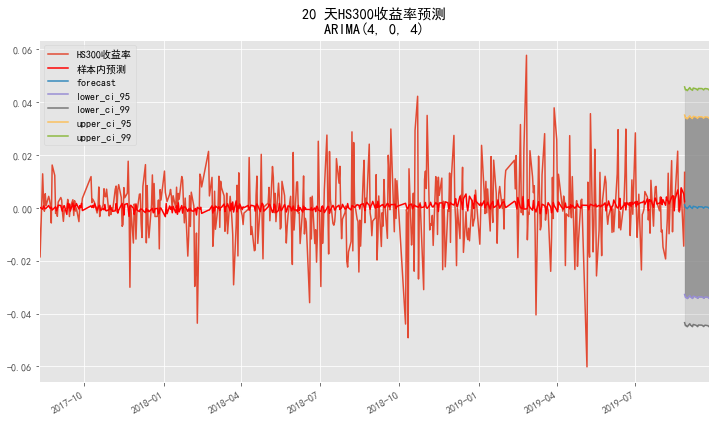

In [104]:
# 对预测的20日收益率数据进行可视化
plt.style.use('ggplot')
fig = plt.figure(figsize=(12,7))
ax = plt.gca()

ts = df['ret'][-500:].copy()
ts.plot(ax=ax, label='HS300收益率')
# 样本内预测
pred = best_mdl.predict(np.arange(len(ts))[0], np.arange(len(ts))[-1])
pf=pd.Series(pred,index=ts.index)
pf.plot(ax=ax, style='r-', label='样本内预测')
fc_all.index=pd.to_datetime(fc_all.index)
fc_all.plot(ax=ax)
plt.fill_between(fc_all.index, fc_all.lower_ci_95, fc_all.upper_ci_95, color='gray', alpha=0.7)
plt.fill_between(fc_all.index, fc_all.lower_ci_99, fc_all.upper_ci_99, color='gray', alpha=0.2)
plt.title('{} 天HS300收益率预测\nARIMA{}'.format(n_steps, best_order))
plt.legend(loc='best', fontsize=10)
plt.show()

# ARCH模型
条件异方差模型，Autoregressive Conditionally Heteroskedastic Models - ARCH(p)  
$$Var(y_t|y_{t-1})=\sigma_t^2=\alpha_0+\alpha_1y_{t-1}^2$$

假设该时间序列均值为0，则模型可以表达为：  
$$y_t=\sigma_t\varepsilon_t, \sigma_t=\sqrt{\alpha_0+\alpha_1y_{t-1}^2},\varepsilon_t \sim iid(0,1)$$

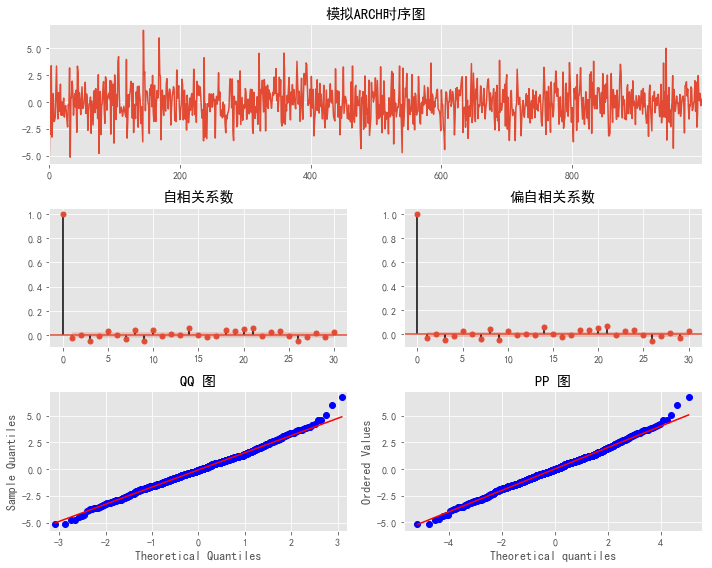

In [108]:
# 模拟ARCH时间序列
np.random.seed(2)
a0 = 2
a1 = .5
y = w = np.random.normal(size=1000)
Y = np.empty_like(y)
for t in range(1,len(y)):
    Y[t] = w[t] * np.sqrt((a0 + a1*y[t-1]**2))
ts_plot(Y, lags=30,title='模拟ARCH')

# GARCH模型
广义条件异方差模型，Generalized Autoregressive Conditionally Heteroskedastic Models - GARCH(p,q)，是ARCH模型的扩展，即GARCH模型的条件方差不仅是滞后残差平方的线性函数，还是滞后条件方差的线性函数，因而GARCH模型适合在计算量不大时，方便地描述高阶的ARCH过程，具有更大的适用性。

$$\varepsilon_t =\sigma_t\omega_t\\ \sigma_t^2 =\alpha_0+\alpha_1\varepsilon_{t-1}^2+\beta_1\sigma_{t-1}^2$$

$\omega_t$为白噪音，$\alpha_1+\beta_1$必须小于1，否则模型将是非平稳的。

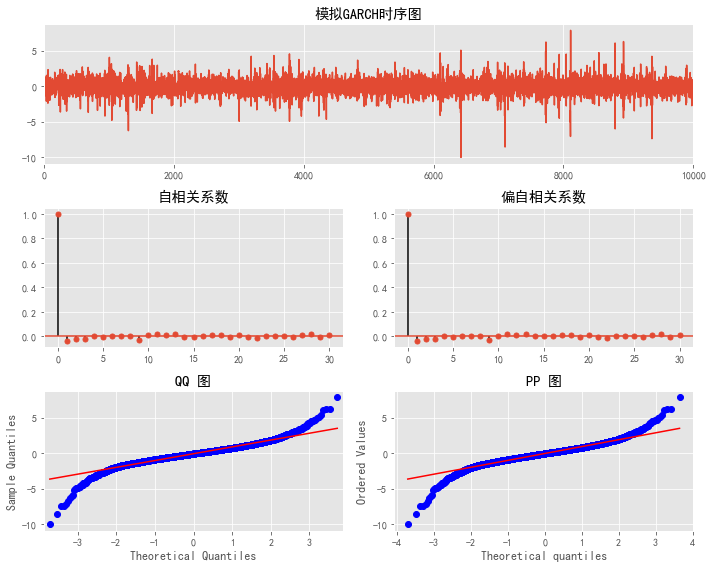

In [110]:
# 模拟GARCH(1, 1) 过程
np.random.seed(3)
a0 = 0.2
a1 = 0.5
b1 = 0.3
n = 10000
w = np.random.normal(size=n)
garch = np.zeros_like(w)
sigsq = np.zeros_like(w)
for i in range(1, n):
    sigsq[i] = a0 + a1*(garch[i-1]**2) + b1*sigsq[i-1]
    garch[i] = w[i] * np.sqrt(sigsq[i])
_ = ts_plot(garch, lags=30,title='模拟GARCH')

In [154]:
# 使用模拟的数据进行 GARCH(1, 1) 模型拟合
am = arch_model(garch)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     38,   Neg. LLF: 12245.080184623937
Iteration:     10,   Func. Count:     71,   Neg. LLF: 12172.55369575378
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 12171.644633786764
            Iterations: 13
            Function evaluations: 89
            Gradient evaluations: 13
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -12171.6
Distribution:                  Normal   AIC:                           24351.3
Method:            Maximum Likelihood   BIC:                           24380.1
                                        No. Observations:                10000
Date:                Wed, Aug 28 2019   Df Residuals:                     9996
Time:       

下面使用GARCH模型对沪深300收益率数据进行拟合。

In [159]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None
    pq_rng = range(5) 
    d_rng = range(2) 
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(method='mle', trend='nc')
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

In [179]:
TS = Y.loc['2015':].copy()
res_tup = _get_best_model(TS.values)

aic: -6206.41804 | order: (3, 0, 2)


In [180]:
# 使用上述估计的最佳阶数进行拟合
order=res_tup[1]
p_ = order[0]
o_ = order[1]
q_ = order[2]
am = arch_model(TS.values, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                      -0.009
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.009
Vol Model:                            GARCH   Log-Likelihood:                2204.20
Distribution:      Standardized Student's t   AIC:                          -4392.40
Method:                  Maximum Likelihood   BIC:                          -4352.12
                                              No. Observations:                 1135
Date:                      Wed, Aug 28 2019   Df Residuals:                     1127
Time:                              15:14:52   Df Model:                            8
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
m

C:\Anaconda3\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


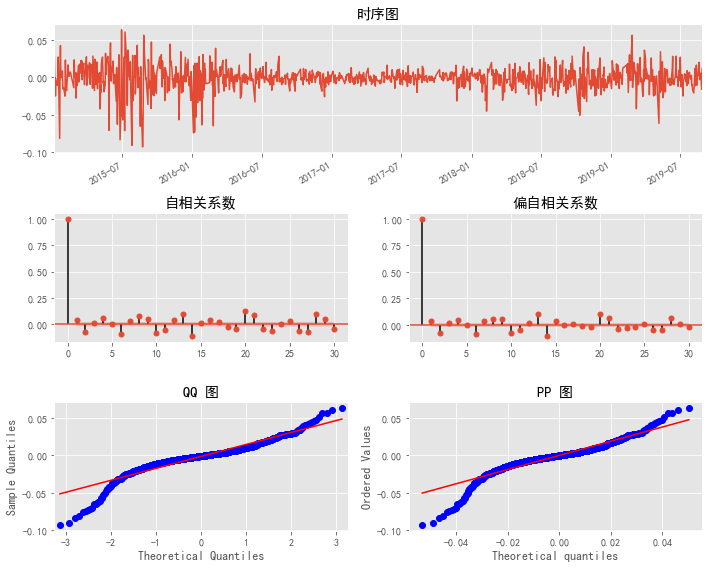

In [181]:
resid=pd.Series(res.resid,index=TS.index)
ts_plot(resid, lags=30)